In [1]:
%matplotlib inline
%config Completer.use_jedi = False

import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16

import matplotlib.pyplot as plt

import healpy as hp
import pysm3
import pysm3.units as u

from scipy.stats.mstats import gmean

from fgbuster import get_instrument, get_sky, get_observation  # Predefined instrumental and sky-creation configurations
import fgbuster.separation_recipes as sr

# Imports needed for component separation
from fgbuster import (CMB, Dust, Synchrotron,  # sky-fitting model
                      MixingMatrix, basic_comp_sep)  # separation routine

from utilities import Mask

In [96]:
import utilities
import importlib
importlib.reload(utilities)

<module 'utilities' from '/global/u2/j/jianyao/foreground/utilities.py'>

In [97]:
from utilities import plot_2d, plot_sky_betas

In [2]:
from cmbdb import cmbdb
import pandas as pd
import time
from fgbuster.visualization import corner_norm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from utilities import Mask

In [9]:
import seaborn as sea

sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

# import data

In [20]:
fres = np.array([2.3, 5, 23, 28, 33]); nu0 = gmean(fres); nside = 32; names = ['SPASS only', 'CBASS only', 'both']

In [6]:
total_IQU = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/total_IQU_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy')#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

In [10]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK

sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

In [19]:
sn_S.shape

(12288,)

`numpy.delete(arr, obj, axis=None)`
- arr: Input array
- obj: Row or column number to delete
- axis: Axis to delete

In [48]:
#Note: input maps should have the mask applied
total_QU = Mask(total_IQU[:, 1:], mask_both)
cbass_only = Mask(total_IQU[1:,1:], mask_both)
spass_only = Mask(np.delete(total_IQU, 1, 0)[:,1:], mask_both)

In [51]:
instrument = pd.DataFrame()
instrument['frequency'] = fres
instrument['depth_p'] = np.array(([8068.89702552, 4497.09426442,  429.10255891,  270.31923344, 423.93603191]))
# instrument['depth_i'] = (np.linspace(20, 40, 10) - 30)**2

In [52]:
instru_cbass = instrument.drop(0)
instru_spass = instrument.drop(1)

In [53]:
instrument

,frequency,depth_p
0,2.3,8068.897026
1,5.0,4497.094264
2,23.0,429.102559
3,28.0,270.319233
4,33.0,423.936032


In [54]:
instru_cbass

,frequency,depth_p
1,5.0,4497.094264
2,23.0,429.102559
3,28.0,270.319233
4,33.0,423.936032


In [55]:
instru_spass

,frequency,depth_p
0,2.3,8068.897026
2,23.0,429.102559
3,28.0,270.319233
4,33.0,423.936032


In [56]:
Synchrotron(23.)

793.1305589244157*(0.0434782608695652*nu)**beta_pl*expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*expm1(0.4049994154739427)**2)

In [57]:
components = [Synchrotron(23.)]

In [58]:
# The starting point of the fit is the pysm default value, so let's shift it

components[0].defaults = [-2.7]

In [59]:
components[0]

793.1305589244157*(0.0434782608695652*nu)**beta_pl*expm1(0.01760867023799751*nu)**2*exp(-0.01760867023799751*nu)/(nu**2*expm1(0.4049994154739427)**2)

In [60]:
result_both = basic_comp_sep(components, instrument, total_QU, nside = nside)

In [93]:
result_both.Sigma[0][0]

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [61]:
s = time.time()
result_spass = basic_comp_sep(components, instru_spass, spass_only, nside = nside)
e = time.time()
print((e-s)/60)
result_cbass = basic_comp_sep(components, instru_cbass, cbass_only, nside = nside)
s = time.time()
print((s-e)/60)

0.6271742900212606
0.5064096490542094


In [65]:
result_both.x[0]

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

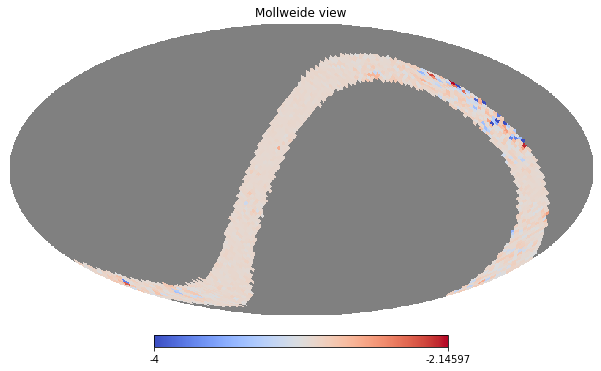

In [64]:
hp.mollview(result_both.x[0], min = -4, cmap = 'coolwarm')

In [ ]:
bins = np.array([-3.39222617, -3.36484438, -3.3374626 , -3.31008081, -3.28269903,
       -3.25531724, -3.22793546, -3.20055367, -3.17317189, -3.1457901 ,
       -3.11840832, -3.09102653, -3.06364475, -3.03626296, -3.00888118,
       -2.98149939, -2.95411761, -2.92673582, -2.89935404, -2.87197225,
       -2.84459046, -2.81720868, -2.78982689, -2.76244511, -2.73506332,
       -2.70768154, -2.68029975, -2.65291797, -2.62553618, -2.5981544 ,
       -2.57077261, -2.54339083, -2.51600904, -2.48862726, -2.46124547,
       -2.43386369, -2.4064819 , -2.37910012, -2.35171833, -2.32433654,
       -2.29695476])

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 5.000e+00,
        1.800e+01, 1.646e+03, 7.400e+01, 6.000e+00]),
 array([-17.21367372, -16.83698123, -16.46028873, -16.08359624,
        -15.70690375, -15.33021126, -14.95351877, -14.57682628,
        -14.20013379, -13.8234413 , -13.44674881, -13.07005632,
        -12.69336383, -12.31667134, -11.93997884, -11.56328635,
        -11.18659386, -10.80990137, -10.43320888, -10.05651639,
         -9.6798239 ,  -9.30313141,  -8.92643892,  -8.54974643,
         -8.17305394,  -7.79636145,  -7.41966895,  -7.04297646,
         -6.66628397,  -6.28959148,  -5.91289899,  -5.

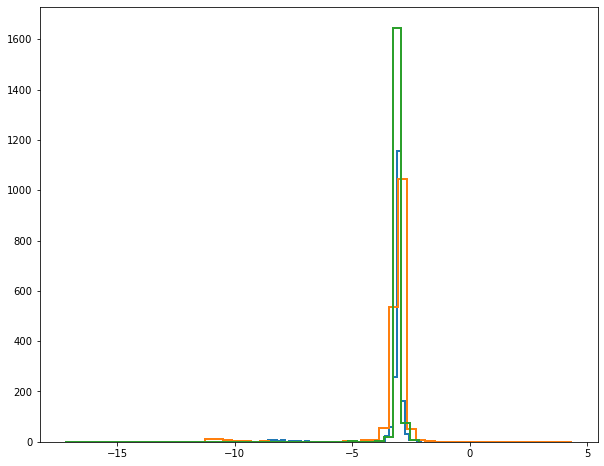

In [67]:
plt.figure(figsize = (10,8))

plt.hist(result_spass.x[0][mask_index],bins = 40,histtype="step", lw = 2)
plt.hist(result_cbass.x[0][mask_index],bins = 40,histtype="step", lw = 2)
plt.hist(result_both.x[0][mask_index],bins = 40,histtype="step", lw = 2)

Text(0.5, 1.0, 'Beta_s of overlapped region, using Fgbuster')

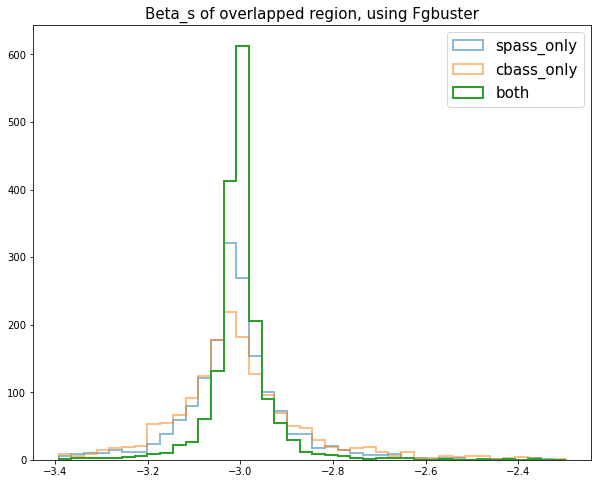

In [129]:
plt.figure(figsize = (10,8))

plt.hist(result_spass.x[0][mask_index],bins = bins,histtype="step", lw = 2, label = 'spass_only', alpha = 0.5)
plt.hist(result_cbass.x[0][mask_index],bins = bins,histtype="step", lw = 2, label = 'cbass_only', alpha = 0.5)
plt.hist(result_both.x[0][mask_index],bins = bins,histtype="step", lw = 2, label = 'both')
plt.legend(fontsize = 15)
# plt.vlines(-3.0,  ymin = 0, ymax = 700, color = 'black')
plt.title('Beta_s of overlapped region, using Fgbuster', fontsize = 15)

# one realization results 

In [92]:
one_betas = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/fgbuster/all_betas_s0_%s_uK_RJ_%03d.npy'%(nside, 0))
one_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/fgbuster/all_sigmas_s0_%s_uK_RJ_%03d.npy'%(nside, 0))

In [103]:
one_sigma[0][mask_index]

array([0.00435344, 0.00693262, 0.00426606, ..., 0.00409712, 0.00269523,
       0.00674585])

0


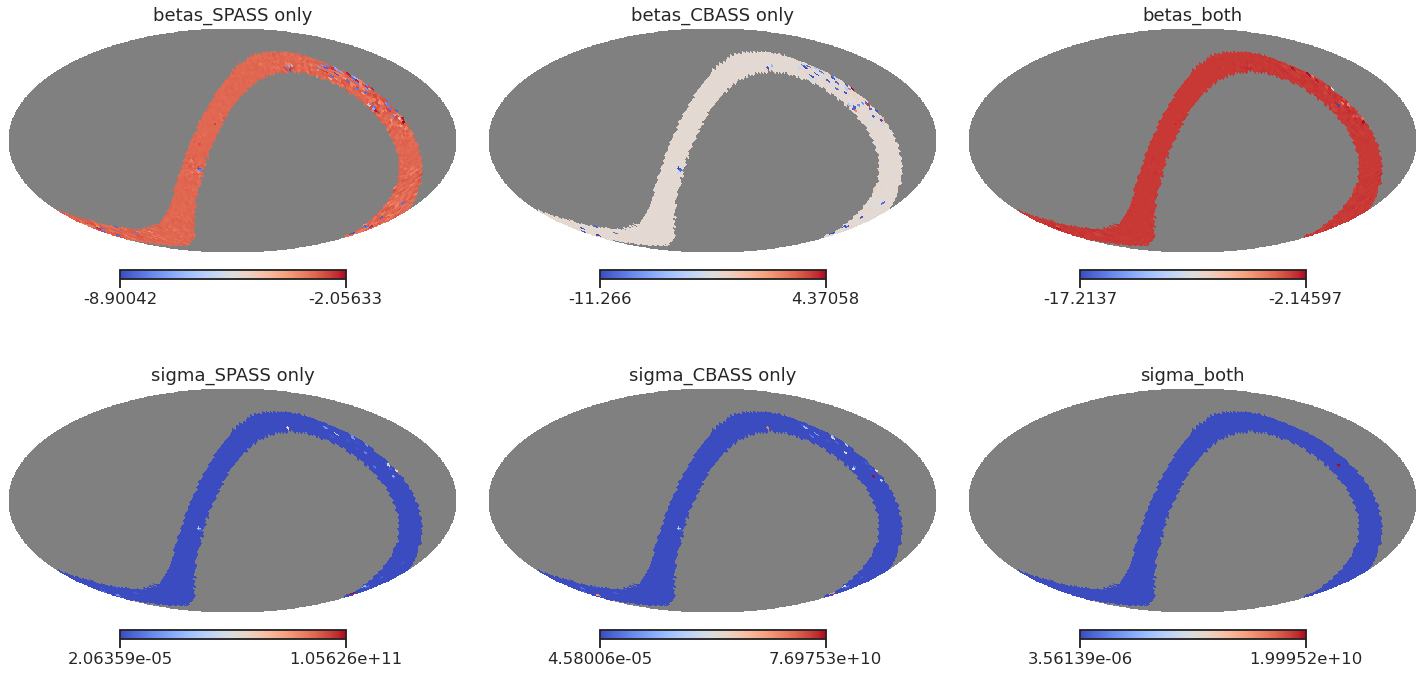

In [99]:
plot_sky_betas('0', names, one_betas, one_sigma, [None, None], [None, None])

In [59]:
betas = [one_betas[0][mask_index], one_betas[1][mask_index], one_betas[2][mask_index]]
sns = [sn_S[mask_index], sn_C[mask_index], sn_both[mask_index]]

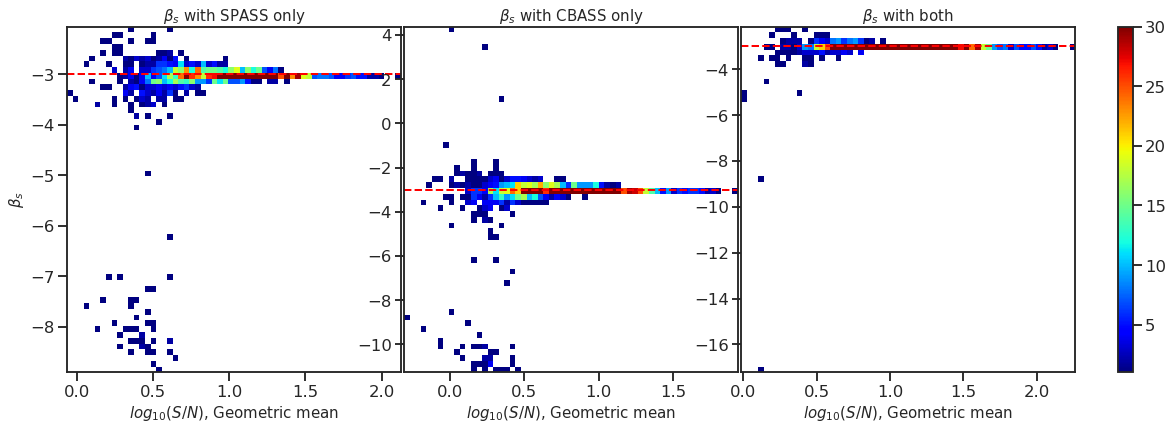

In [68]:
plot_2d(betas, sns, 60, 60, names)

# 50 realizations results

In [86]:
N = 50
all_betas = np.zeros((3, 12*nside**2)); ## 3 cases 
for i in range(N):
    one_betas = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/fgbuster/all_betas_s0_%s_uK_RJ_%03d.npy'%(nside, i))
    all_betas += one_betas
all_betas = all_betas/N

In [82]:
# plot_sky_betas(all_betas, all_sigmas, names, '50')

In [87]:
betas_masked = [all_betas[0][mask_index], all_betas[1][mask_index], all_betas[2][mask_index]]

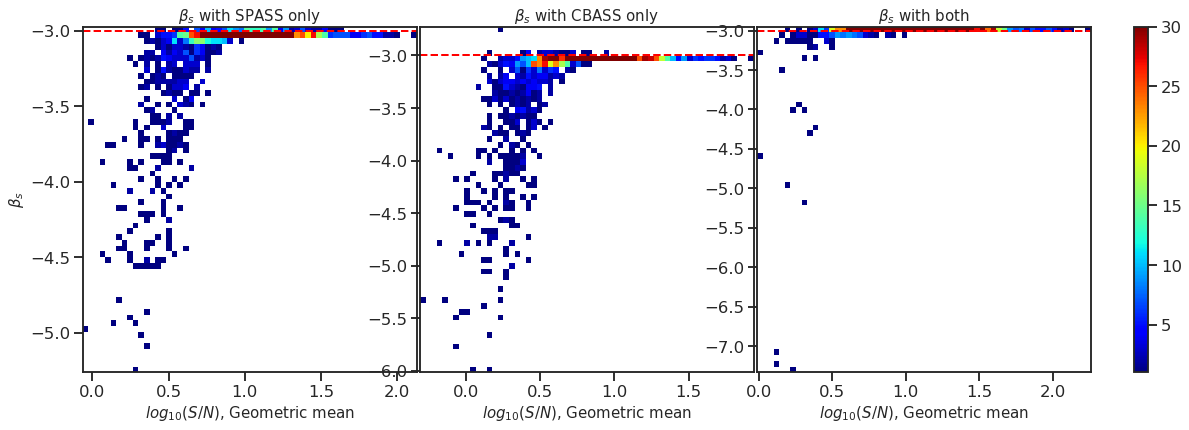

In [88]:
plot_2d(betas_masked, sns, 60,60, names)

Text(0.5, 1.0, 'Beta_s of overlapped region, using Fgbuster')

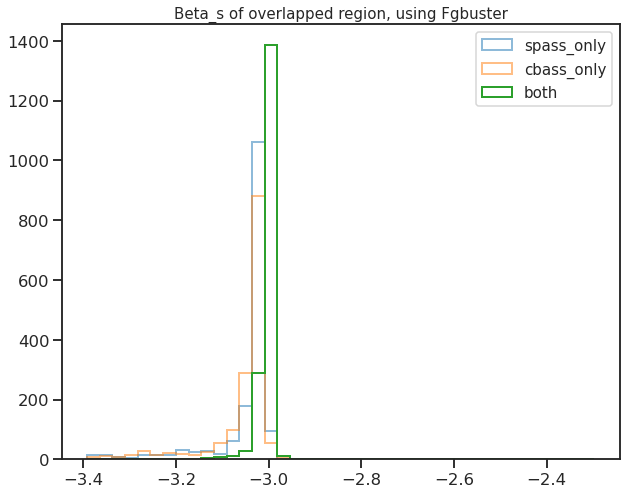

In [91]:
plt.figure(figsize = (10,8))

plt.hist(all_betas[0][mask_index],bins = bins,histtype="step", lw = 2, label = 'spass_only', alpha = 0.5)
plt.hist(all_betas[1][mask_index],bins = bins,histtype="step", lw = 2, label = 'cbass_only', alpha = 0.5)
plt.hist(all_betas[2][mask_index],bins = bins,histtype="step", lw = 2, label = 'both')
plt.legend(fontsize = 15)
# plt.vlines(-3.0,  ymin = 0, ymax = 700, color = 'black')
plt.title('Beta_s of overlapped region, using Fgbuster', fontsize = 15)

# comparision with Rician likelihood

## realization seed 0

In [117]:
dyne = []
dyne.append(np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_only_000.npy')[2:7019:4])
dyne.append(np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_CBASS_only_000.npy')[2:7019:4])
dyne.append(np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_CBASS_000.npy')[2:7019:4])

In [116]:
dyne[0].shape

(1755,)

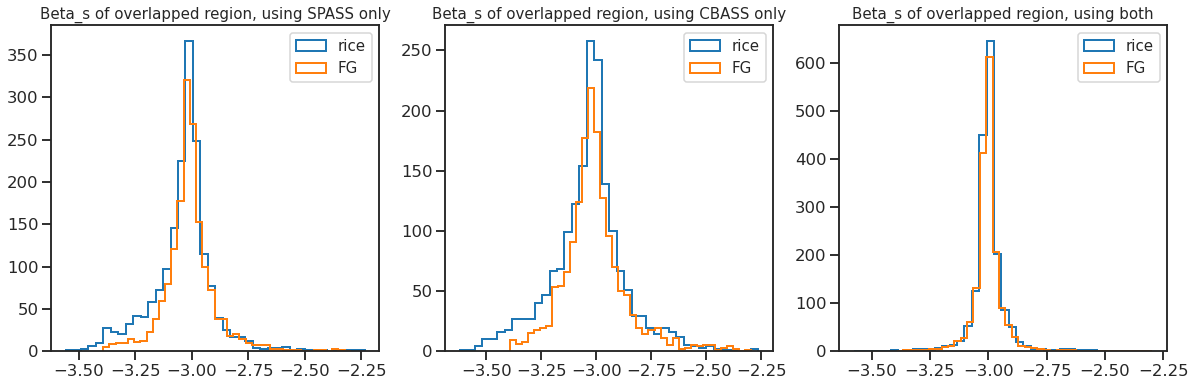

In [132]:
fig, ax = plt.subplots(1,3,figsize = (20,6))
for i in range(3):
    ax[i].hist(dyne[i],  bins = 40, histtype="step" , label = 'rice', lw = 2)
    ax[i].hist(one_betas[i][mask_index],  bins = bins, histtype="step", label = 'FG', lw = 2)
    ax[i].set_title('Beta_s of overlapped region, using %s'%names[i], fontsize = 15)
    ax[i].legend(fontsize = 15)

## 50 realizations

In [123]:
def combine(name,nside, N, mask_index):
    betas_all = np.zeros((N, 12*nside**2))
    for j in range(N):
        results= np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_%s_with_%s_%03d.npy'%(nside, name,j))
        betas_all[j] = utilities.Bp2f(results,mask_index, nside = nside)[2]
    
    mean = np.mean(betas_all, axis = 0)
    std = np.std(betas_all, axis = 0); std_masked = np.ma.masked_where(std>100, std)
    return mean, std_masked.filled(fill_value = hp.UNSEEN)

In [125]:
beta_both_mean = combine('SPASS_CBASS', 32, 10, mask_index)[0]
beta_S_mean = combine('SPASS_only', 32, 10, mask_index)[0]
beta_C_mean = combine('CBASS_only', 32, 10, mask_index)[0]

mean_betas = np.array([beta_S_mean[mask_index], beta_C_mean[mask_index], beta_both_mean[mask_index]])

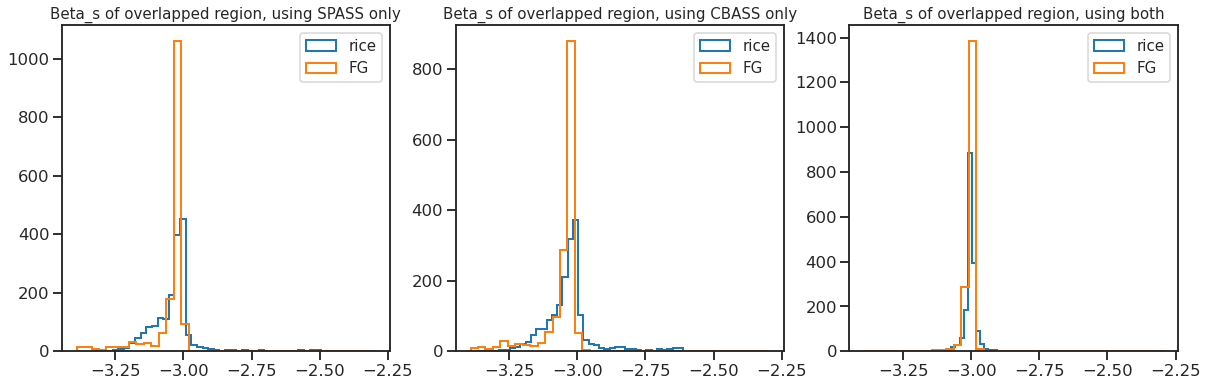

In [131]:
fig, ax = plt.subplots(1,3,figsize = (20,6))
for i in range(3):
    ax[i].hist(mean_betas[i],  bins = 40, histtype="step" , label = 'rice', lw = 2)
    ax[i].hist(betas_masked[i],  bins = bins, histtype="step", label = 'FG', lw = 2)
    ax[i].set_title('Beta_s of overlapped region, using %s'%names[i], fontsize = 15)
    ax[i].legend(fontsize = 15)

(1755,)